In [2]:
import pandas as pd

In [3]:
wine = pd.read_csv('./datasets/winequality-white.csv',sep=';')

Helper functions to plot kMeans evaluation metrics

In [21]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np

def bench_k_means(kmeans, init, n_clusters, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [init, n_clusters, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    if n_clusters == 1:
        results += [None]
    else:
        results += [
            np.round(metrics.silhouette_score(
                data,
                estimator[-1].labels_,
                metric="euclidean",
                sample_size=300,
            ), 3)
        ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:d}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}"
    )
    print(formatter_result.format(*results))

    return results

def plot_clustering_metrics(ax, title, y_axis, x_axis, values, n_clusters_values):
    ax.set_xticks(n_clusters_values)
    for key in values:
        ax.plot(n_clusters_values, values[key])
    ax.set_title(title)
    ax.set(xlabel=x_axis, ylabel=y_axis)
    ax.grid()
    ax.legend(values.keys())

In [5]:
from sklearn.cluster import KMeans

wine_Y = wine['quality'].values
wine_X = wine.drop('quality', axis=1).values

n_clusters_values = range(1, 31)
init_values = ['k-means++', 'random']

print(90 * "_")
print("init\t\tk\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
wcss = {init:[] for init in init_values}
silhouette = {init:[] for init in init_values}
fit_time = {init:[] for init in init_values}
homogeneity_score = {init:[] for init in init_values}
for init in init_values:
    for n_clusters in n_clusters_values:
        kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=42)
        _, _, ft, inertia, homo, compl, v_meas, ari, ami, silh = bench_k_means(kmeans, init, n_clusters, wine_X, wine_Y)
        wcss[init].append(inertia)
        silhouette[init].append(silh)
        fit_time[init].append(ft)
        homogeneity_score[init].append(homo)

__________________________________________________________________________________________
init		k	time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1	0.888s	53878	0.000	1.000	0.000	0.000	-0.000	None
k-means++	2	0.871s	42549	0.036	0.069	0.048	0.025	0.047	0.247
k-means++	3	0.929s	39063	0.038	0.045	0.041	0.034	0.040	0.009
k-means++	4	0.941s	35987	0.038	0.042	0.040	0.029	0.039	0.006
k-means++	5	1.003s	33699	0.055	0.049	0.052	0.038	0.050	-0.04
k-means++	6	1.227s	31972	0.084	0.066	0.074	0.045	0.072	-0.076
k-means++	7	1.309s	30553	0.085	0.060	0.070	0.034	0.068	-0.039
k-means++	8	1.046s	29360	0.094	0.063	0.075	0.035	0.073	-0.159
k-means++	9	1.205s	28199	0.093	0.058	0.071	0.031	0.068	-0.11
k-means++	10	1.205s	27447	0.099	0.058	0.073	0.033	0.070	-0.133
k-means++	11	1.231s	26788	0.099	0.055	0.071	0.028	0.068	-0.148
k-means++	12	1.357s	26133	0.095	0.051	0.067	0.024	0.063	-0.222
k-means++	13	1.186s	25571	0.100	0.052	0.068	0.023	0.065	-0.149
k-means++	14	1.157s	25117	0.099	0.050	0.067	0.0

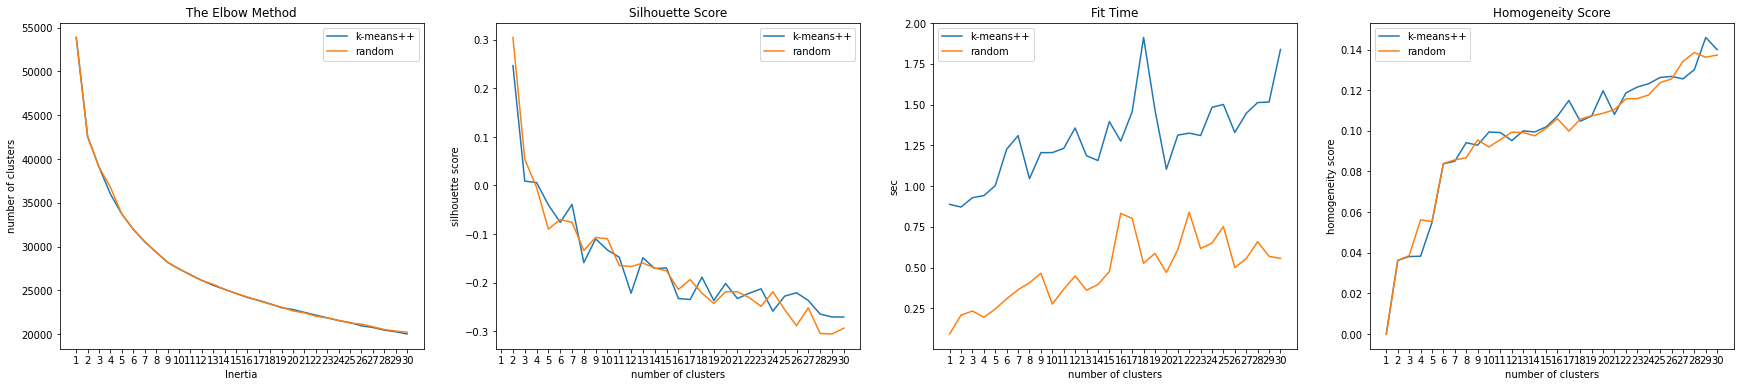

In [6]:
_, ax = plt.subplots(1, 4, figsize=(30, 6))
plot_clustering_metrics(ax[0], 'The Elbow Method', 'number of clusters', 'Inertia', wcss, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette, n_clusters_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of clusters', fit_time, n_clusters_values)
plot_clustering_metrics(ax[3], 'Homogeneity Score', 'homogeneity score', 'number of clusters', homogeneity_score, n_clusters_values)
plt.show()

In [7]:
def bench_em(em, covariance_type, n_components, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    em.fit(data)
    fit_time = time() - t0
    results = [covariance_type, n_components, fit_time, em.bic(data)]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    labels_ = em.predict(data)
    results += [m(labels, labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    if len(set(labels_)) == 1:
        results += [None]
    else:
        results += [
            np.round(metrics.silhouette_score(
                data,
                labels_,
                metric="euclidean",
                sample_size=300,
            ), 3)
        ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:d}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}"
    )
    print(formatter_result.format(*results))

    return results

In [8]:
from sklearn.mixture import GaussianMixture

n_components_values = range(1, 31)
covariance_type_values = ['full', 'tied', 'diag', 'spherical']

print(90 * "_")
print("cov\t\tk\ttime\tbic\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

bic = {covariance_type:[] for covariance_type in covariance_type_values}
silhouette = {covariance_type:[] for covariance_type in covariance_type_values}
fit_time = {covariance_type:[] for covariance_type in covariance_type_values}
homogeneity_score = {covariance_type:[] for covariance_type in covariance_type_values}
for covariance_type in covariance_type_values:
    for n_components in n_components_values:
        em = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        _, _, ft, b, homo, compl, v_meas, ari, ami, silh = bench_em(em, covariance_type, n_components, wine_X, wine_Y)
        em.fit(wine_X)
        bic[covariance_type].append(b)
        silhouette[covariance_type].append(silh)
        fit_time[covariance_type].append(ft)
        homogeneity_score[covariance_type].append(homo)

__________________________________________________________________________________________
cov		k	time	bic	homo	compl	v-meas	ARI	AMI	silhouette
full     	1	0.100s	35346	0.000	1.000	0.000	0.000	-0.000	None
full     	2	0.190s	26680	0.030	0.107	0.046	0.018	0.046	0.115
full     	3	0.363s	23473	0.027	0.038	0.031	0.017	0.030	-0.014
full     	4	0.227s	21638	0.041	0.044	0.043	0.023	0.041	-0.031
full     	5	0.344s	19910	0.059	0.053	0.056	0.035	0.054	-0.045
full     	6	0.540s	19507	0.048	0.040	0.044	0.035	0.042	-0.08
full     	7	0.602s	19225	0.048	0.036	0.041	0.024	0.039	-0.11
full     	8	0.596s	19252	0.071	0.051	0.059	0.029	0.057	-0.122
full     	9	0.860s	19685	0.057	0.041	0.048	0.028	0.045	-0.141
full     	10	0.739s	19140	0.068	0.047	0.055	0.020	0.052	-0.171
full     	11	1.223s	18966	0.082	0.052	0.064	0.024	0.060	-0.262
full     	12	1.013s	19295	0.091	0.057	0.070	0.029	0.066	-0.177
full     	13	1.010s	19510	0.086	0.052	0.065	0.025	0.061	-0.273
full     	14	0.934s	20010	0.083	0.049	0.061	0.020	

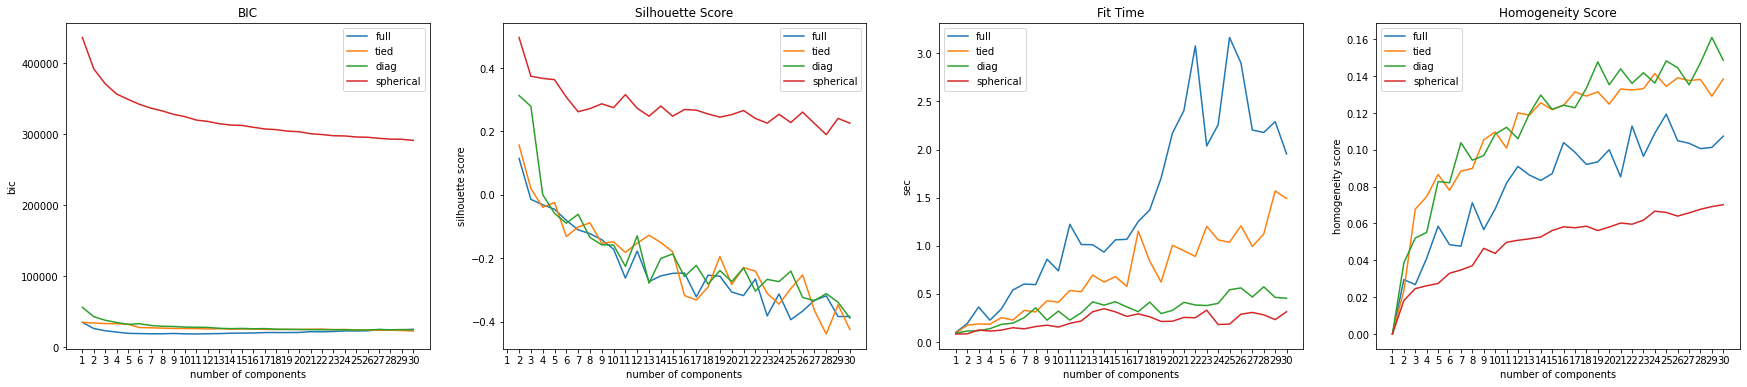

In [9]:
_, ax = plt.subplots(1, 4, figsize=(30, 6))
plot_clustering_metrics(ax[0], 'BIC', 'bic', 'number of components', bic, n_components_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of components', silhouette, n_components_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of components', fit_time, n_components_values)
plot_clustering_metrics(ax[3], 'Homogeneity Score', 'homogeneity score', 'number of components', homogeneity_score, n_components_values)
plt.show()

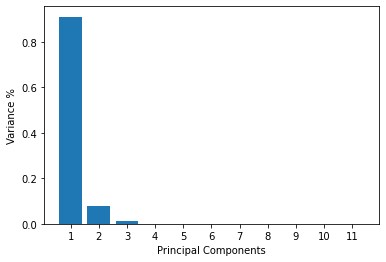

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11, random_state=42)
estimator = make_pipeline(StandardScaler(), pca)
principal_components = estimator[-1].fit_transform(wine_X)

x_range = range(1, pca.n_components_+1)
plt.bar(x_range, pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(x_range)
plt.show()


In [28]:
from sklearn.decomposition import FastICA

kurtosis = []
for n_components in range(1, 12):
    ica = FastICA(n_components=n_components, random_state=42)
    estimator = make_pipeline(StandardScaler(), ica)
    independent_components = estimator[-1].fit_transform(wine_X)
    independent_components = pd.DataFrame(independent_components)
    k = independent_components.kurt(axis=0)
    kurtosis.append(k.abs().mean())

x_range = range(1, 12)
plt.bar(x_range, kurtosis)
plt.axhline(y=3, color='gray', linestyle='--', label='Gaussian')
plt.xlabel('Independent Components')
plt.ylabel('Kurtosis')
plt.xticks(x_range)
plt.yticks(range(1,11))
plt.ylim(0, 10)
plt.legend()
plt.show()


AttributeError: 'FastICA' object has no attribute 'feature_names_in_'

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

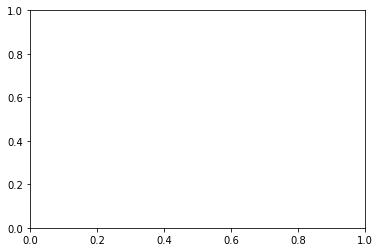

In [81]:
from sklearn.random_projection import SparseRandomProjection

data_needed = []
for n_components in range(1, 12):
    rp = SparseRandomProjection(n_components=n_components, random_state=42)
    estimator = make_pipeline(StandardScaler(), rp)
    random_components = estimator[-1].fit_transform(wine_X)
    data_needed.append(rp.components_.shape[1])

print(data_needed)

x_range = range(1, 12)
plt.bar(x_range, kurtosis)
plt.axhline(y=3, color='gray', linestyle='--', label='Gaussian')
plt.xlabel('Independent Components')
plt.ylabel('Kurtosis')
plt.xticks(x_range)
plt.yticks(range(1,11))
plt.ylim(0, 10)
plt.legend()
plt.show()

In [ ]:
def bench_k_means_dimensionality_reduction(kmeans, pca, method, n_clusters, n_components, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), pca)
    principal_components = pd.DataFrame(estimator[-1].fit_transform(data))
    classifier = kmeans.fit(principal_components.iloc[:,:n_components])
    fit_time = time() - t0
    results = [method, n_clusters, fit_time, classifier.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, classifier.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    if n_clusters == 1:
        results += [None]
    else:
        results += [
            np.round(metrics.silhouette_score(
                data,
                classifier.labels_,
                metric="euclidean",
                sample_size=300,
            ), 3)
        ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:d}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}"
    )
    print(formatter_result.format(*results))

    return results

In [78]:


n_clusters_values = range(1, 31)

print(90 * "_")
print("init\t\tk\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

methods = ['kmeans', 'PCA', 'ICA', 'Random Projection']
wcss = {method:[] for method in methods}
silhouette = {method:[] for method in methods}
fit_time = {method:[] for method in methods}
homogeneity_score = {method:[] for method in methods}
adjusted_mutual_info_score = {method:[] for method in methods}
for method in methods:
    for n_clusters in n_clusters_values:
        kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=42)
        if method == 'PCA':
            pca = PCA(n_components=None, random_state=42)
            _, _, ft, inertia, homo, compl, v_meas, ari, ami, silh = bench_k_means_dimensionality_reduction(kmeans, pca, method, n_clusters, 3, wine_X, wine_Y)
        elif method == 'ICA':
            ica = FastICA(n_components=None, random_state=42)
            _, _, ft, inertia, homo, compl, v_meas, ari, ami, silh = bench_k_means_dimensionality_reduction(kmeans, ica, method, n_clusters, 11, wine_X, wine_Y)
        elif method == 'random':
            rp = SparseRandomProjection(n_components=4, random_state=42)
            _, _, ft, inertia, homo, compl, v_meas, ari, ami, silh = bench_k_means_dimensionality_reduction(kmeans, rp, method, n_clusters, 4, wine_X, wine_Y)
        else:
            _, _, ft, inertia, homo, compl, v_meas, ari, ami, silh = bench_k_means(kmeans, method, n_clusters, wine_X, wine_Y)
        wcss[method].append(inertia)
        silhouette[method].append(silh)
        fit_time[method].append(ft)
        homogeneity_score[method].append(homo)
        adjusted_mutual_info_score[method].append(ami)


__________________________________________________________________________________________
init		k	time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
kmeans   	1	0.133s	53878	0.000	1.000	0.000	0.000	-0.000	None
kmeans   	2	0.192s	42549	0.036	0.069	0.048	0.026	0.047	0.296
kmeans   	3	0.228s	39063	0.039	0.045	0.042	0.034	0.041	0.042
kmeans   	4	0.326s	36756	0.056	0.053	0.054	0.043	0.053	-0.002
kmeans   	5	0.294s	33699	0.055	0.049	0.052	0.038	0.050	-0.06
kmeans   	6	0.388s	31971	0.084	0.066	0.074	0.045	0.072	-0.071
kmeans   	7	0.327s	30560	0.086	0.061	0.071	0.034	0.069	-0.105
kmeans   	8	0.365s	29385	0.087	0.057	0.069	0.032	0.066	-0.063
kmeans   	9	0.447s	28199	0.095	0.059	0.073	0.032	0.070	-0.125
kmeans   	10	0.339s	27469	0.092	0.054	0.068	0.029	0.065	-0.112
kmeans   	11	0.518s	26749	0.096	0.054	0.069	0.027	0.065	-0.127
kmeans   	12	0.585s	26122	0.099	0.053	0.069	0.025	0.066	-0.157
kmeans   	13	0.457s	25686	0.099	0.051	0.068	0.024	0.064	-0.147
kmeans   	14	0.579s	25105	0.098	0.049	0.065	0

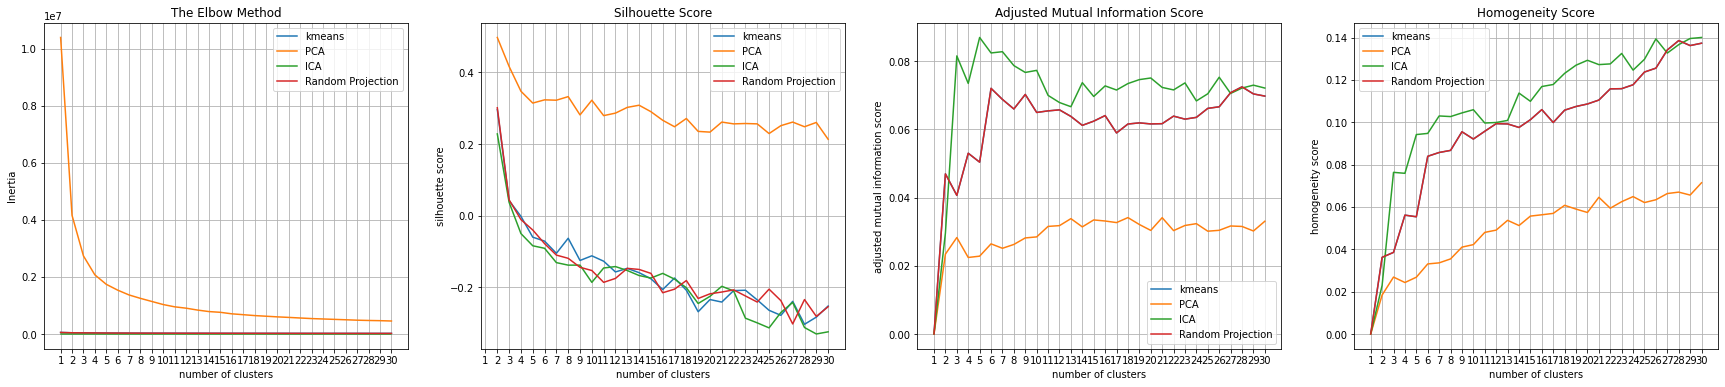

In [79]:
_, ax = plt.subplots(1, 4, figsize=(30, 6))
plot_clustering_metrics(ax[0], 'The Elbow Method', 'Inertia', 'number of clusters', wcss, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette, n_clusters_values)
plot_clustering_metrics(ax[2], 'Adjusted Mutual Information Score', 'adjusted mutual information score', 'number of clusters', adjusted_mutual_info_score, n_clusters_values)
plot_clustering_metrics(ax[3], 'Homogeneity Score', 'homogeneity score', 'number of clusters', homogeneity_score, n_clusters_values)
plt.show()


In [80]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(42)
X = rng.rand(100, 10000)
print(len(X[0]))
transformer = SparseRandomProjection(random_state=rng, eps=0.1, n_components=6)
X_new = transformer.fit_transform(wine_X)
X_new.shape

# print(transformer.components_)
# np.mean(transformer.components_ != 0)

10000


(4898, 6)